# simple mathematical language model checker

In [1]:
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import random
from multiprocessing.pool import ThreadPool
import os

In [ ]:
ops = ['-', '+', '/', '*', '^']
EMPTY = 'EMPTY'
NUM = 'NUM'
EQ_SIGN = '='
sl_vocabulary = ops + [EQ_SIGN, NUM, EMPTY] # has to be in this order, DO NOT TOUCH
dictionary = {el:idx for idx,el in enumerate(sl_vocabulary)}

def sl_gen_sample(length, max_vector_len):
  values = []
  for _ in range(length):
    values.append(dictionary[NUM])
    values.append(random.randint(0, len(ops)-1))
  values += [dictionary[NUM],dictionary[EQ_SIGN],dictionary[NUM]]
  filled_to_the_brim = values + [dictionary[EMPTY] for _ in range(max_vector_len - len(values))]
  return filled_to_the_brim

def sl_generate_samples(num_samples, min_len, max_len, max_vector_len):
  lens = np.random.randint(min_len, max_len, num_samples)
  return np.asarray([sl_gen_sample(l, max_vector_len) for l in lens])

def sl_decode_sample(sample):
  return [sl_vocabulary[int(v + 0.5)] for v in sample]

In [ ]:
def prepare_record(parsed_file):
  parsed = np.loadtxt(parsed_file, dtype=float, converters=float)
  return parsed

def load_dataset(parsed_dir, max_size=None) -> list:
  parsed_files = sorted(os.listdir(parsed_dir))
  if max_size:
    parsed_files = parsed_files[:max_size]

  with ThreadPool() as pool:
    parsed_files = pool.map(lambda f: f"{parsed_dir}{f}", parsed_files)
    files = list(parsed_files)

  with ThreadPool() as pool:
  #   # pool.map guaranteese to preserve order
  #   # pool.map 'consumes' mapping created in previous with block
  #   # map() function returns a generator that is exhausted after is it used
    return [np.array(pool.map(lambda file: prepare_record(file), files)), files]

In [ ]:
def scale_dataset_down(dataset, dic_size):
    l = lambda x: (x / (dic_size - 1))
    return np.array(list(map(l, dataset)))

In [ ]:
def scale_dataset(dataframe, dic_size):
    l = lambda x: (x) * (dic_size - 1)
    return np.array(list(map(l, dataframe)))

In [ ]:
def sinusoidal_embedding(x, embedding_min_frequency, embedding_max_frequency, embedding_dims):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=1
    )
    return embeddings

In [ ]:
def get_network(tokens_capacity, embedding_min_frequency, embedding_max_frequency, embedding_dims):
    noisy_images = keras.Input(shape=(tokens_capacity))
    noise_variances = keras.Input(shape=(1))

    emb = lambda x: sinusoidal_embedding(x, embedding_min_frequency, embedding_max_frequency, embedding_dims)
    e = layers.Lambda(emb)(noise_variances)

    x = layers.Dense(1024)(noisy_images)
    x = layers.Concatenate()([x, e])
    x = layers.Dense(512, name="dense01")(x)
    x = layers.Dense(1024, name="dense02", activation=keras.activations.relu)(x)
    x = layers.Dense(2048, name="dense03", activation=keras.activations.relu)(x)
    x = layers.Dense(tokens_capacity, name="last_dense")(x)

    return keras.Model([noisy_images, noise_variances], x, name="simple_net")

In [ ]:

class DiffusionModel(keras.Model):
    def __init__(
      self, tokens_capacity, dictionary_size, network,
      max_signal_rate, min_signal_rate,
    ):
        super().__init__()

        self.tokens_capacity = tokens_capacity
        self.dictionary_size = dictionary_size
        self.network = network
        self.max_signal_rate = max_signal_rate
        self.min_signal_rate = min_signal_rate
        self.normalizer = layers.Normalization()

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss") # for training
        self.sample_loss_tracker = keras.metrics.Mean(name="i_loss") # for human evaluation

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.sample_loss_tracker]

    def denormalize(self, samples):
        samples = self.normalizer.mean + samples * self.normalizer.variance**0.5
        return samples

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(self.max_signal_rate)
        end_angle = tf.acos(self.min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_samples, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        network = self.network

        # predict noise component and calculate the sample component using it
        pred_noises = network([noisy_samples, noise_rates**2], training=training)
        pred_samples = (noisy_samples - noise_rates * pred_noises) / signal_rates # maybe some more sophisticated way of removing noise

        return pred_noises, pred_samples

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_samples = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy sample" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_samples = initial_noise
        for step in range(diffusion_steps):
            noisy_samples = next_noisy_samples

            # separate the current noisy sample to its components
            diffusion_times = tf.ones((num_samples)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            signal_rates = tf.expand_dims(signal_rates, axis=1)
            noise_rates = tf.expand_dims(noise_rates, axis=1)

            pred_noises, pred_samples = self.denoise(
                noisy_samples, noise_rates, signal_rates, training=False
            )
            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_signal_rates = tf.expand_dims(next_signal_rates, axis=1)
            next_noise_rates = tf.expand_dims(next_noise_rates, axis=1)
            next_noisy_samples = (
                next_signal_rates * pred_samples + next_noise_rates * pred_noises
            )
            # this new noisy sample will be used in the next step

        return pred_samples

    # generated values should be between 0 and 1, network should work better this way
    def generate(self, num_samples, diffusion_steps):
        # Generate sample from complete noise
        initial_noise = tf.random.normal(shape=(num_samples, self.tokens_capacity))
        generated_sample = self.reverse_diffusion(initial_noise, diffusion_steps)
        denormalized_generated_sample = self.denormalize(generated_sample)
        return generated_sample, tf.clip_by_value(tf.math.abs(denormalized_generated_sample), 0, 1)

In [ ]:
# from samples, I deducted that cp-0511 is a little bit better model for some unknown reason
checkpoint_path = "simplest_language_model\\cp-0511\\model"

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95
    
# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
embedding_min_frequency = 1.0

# dictionary related
SIMPLE_MATH_DICTIONARY_SIZE = 8 # 246
TOKENS_CAPACITY = 128 # 2048

data_dir = f"../data/simplest_language_model/"
dataset, filenames = load_dataset(data_dir)
dataset = scale_dataset_down(dataset, SIMPLE_MATH_DICTIONARY_SIZE)
    
network = get_network(TOKENS_CAPACITY, embedding_min_frequency, embedding_max_frequency, embedding_dims)
network.summary()
print("Network created")

model = DiffusionModel(TOKENS_CAPACITY, SIMPLE_MATH_DICTIONARY_SIZE, network, max_signal_rate, min_signal_rate)
print("Model created")

model.compile(
    optimizer = keras.optimizers.experimental.AdamW(learning_rate=0, weight_decay=0),
    loss = keras.losses.mean_absolute_error
)
model.normalizer.adapt(dataset)

model.load_weights(checkpoint_path)

In [2]:
from matplotlib import pyplot as plt

In [3]:
raw, denormalized = model.generate(5,100)

NameError: name 'model' is not defined

In [ ]:
with np.printoptions(precision=3, floatmode='fixed'):
    for idx in range(len(denormalized)):
      print(raw[idx])
      print(denormalized[idx])
      scaled = scale_dataset(denormalized[idx], SIMPLE_MATH_DICTIONARY_SIZE)
      print(" ".join(sl_decode_sample(scaled)))

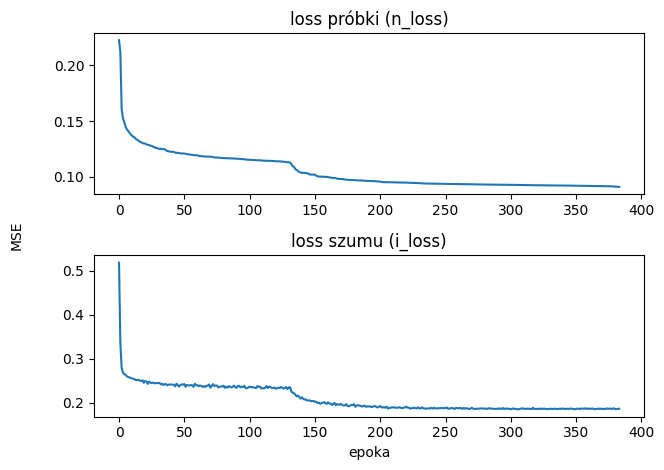

In [52]:
def plot_things(data_path):
  '''
    data will always have epoch number as its first column
  '''
  data = np.genfromtxt(data_path, dtype=float, delimiter=',', names=True)
  labels = data.dtype.names


  fig, ax = plt.subplots(len(labels) - 1, 1)
  loss_labs = ["loss próbki", "loss szumu"]
  for count, label in enumerate(labels[1:]):
    ax[count].set_title(loss_labs[count] + f" ({label})")
    ax[count].plot(data[label])

  plt.xlabel("epoka")
  # plt.ylabel("MSE")
  fig.text(-0.02, 0.5, 'MSE', ha='center', va='center', rotation='vertical')
  fig.tight_layout()
  return fig

path_to_csv ="history_simple_c_v3.csv"
fig = plot_things(path_to_csv)